# maxvogt-analysis: Hinwil

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [HI007](https://mtwente.github.io/maxvogt/items/hi007.html)
- [HI098 (Former Station Fountain)](https://mtwente.github.io/maxvogt/items/hi098.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Fhinwil.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Hinwil, Switzerland'
local_crs = 'EPSG:2056'

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [4]:
buildings = osmnx.features.features_from_place(place, tags={'building':True})

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/sit

In [5]:
buildings

amenity  \
element_type osmid                
way          37866122       NaN   
             41459178       NaN   
             44949587       NaN   
             197215043      NaN   
             197215048      NaN   
...                         ...   
             1301798699     NaN   
             1301823519     NaN   
             1301826157     NaN   
             1301826158     NaN   
relation     11087211       NaN   

                                                                  geometry  \
element_type osmid                                                           
way          37866122    POLYGON ((8.83705 47.29927, 8.83706 47.29941, ...   
             41459178    POLYGON ((8.81779 47.28818, 8.81808 47.28830, ...   
             44949587    POLYGON ((8.86082 47.28769, 8.86088 47.28765, ...   
             197215043   POLYGON ((8.88630 47.29361, 8.88635 47.29363, ...   
             197215048   POLYGON ((8.88374 47.28935, 8.88392 47.28931, ...   
...                                                                    ...   
             1301798699  POLYGON ((8.82942 47.30525, 8.82945 47.30522, ...   
             1301823519  POLYGON ((8.82266 47.30428, 8.82283 47.30431, ...   
             1301826157  POLYGON ((8.82220 47.30355, 8.82217 47.30353, ...   
             1301826158  POLYGON ((8.82190 47.30373, 8.82186 47.30370, ...   
relation     11087211    POLYGON ((8.82445 47.30550, 8.82429 47.30518, ...   

                        power opening_hours      operator phone  \
element_type osmid                                                
way          37866122     NaN           NaN  Hiwi-Märt AG   NaN   
             41459178     NaN           NaN           NaN   NaN   
             44949587     NaN           NaN           NaN   NaN   
             197215043    NaN           NaN           NaN   NaN   
             197215048    NaN           NaN           NaN   NaN   
...                       ...           ...           ...   ...   
             1301798699   NaN           NaN           NaN   NaN   
             1301823519   NaN           NaN           NaN   NaN   
             1301826157   NaN           NaN           NaN   NaN   
             1301826158   NaN           NaN           NaN   NaN   
relation     11087211     NaN           NaN           NaN   NaN   

                             addr:city addr:housenumber addr:postcode  \
element_type osmid                                                      
way          37866122           Hinwil               14          8340   
             41459178           Hinwil               10          8340   
             44949587              NaN              NaN           NaN   
             197215043             NaN              NaN           NaN   
             197215048   Wernetshausen              104          8342   
...                                ...              ...           ...   
             1301798699         Hinwil             76.1          8340   
             1301823519            NaN              NaN           NaN   
             1301826157            NaN              NaN           NaN   
             1301826158            NaN              NaN           NaN   
relation     11087211              NaN              NaN           NaN   

                                 addr:street  ... old_name shelter_type  \
element_type osmid                            ...                         
way          37866122        Gossauerstrasse  ...      NaN          NaN   
             41459178    Affeltrangerstrasse  ...      NaN          NaN   
             44949587                    NaN  ...      NaN          NaN   
             197215043                   NaN  ...      NaN          NaN   
             197215048        Bachtelstrasse  ...      NaN          NaN   
...                                      ...  ...      ...          ...   
             1301798699        Zürichstrasse  ...      NaN          NaN   
             1301823519                  NaN  ...      N

In [6]:
buildings.geom_type.value_counts()

Polygon    3371
Name: count, dtype: int64

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [9]:
buildings["uID"] = range(len(buildings))

In [10]:
buildings

geometry   uID
0     POLYGON ((2705760.176 1239652.098, 2705761.127...     0
1     POLYGON ((2704325.296 1238392.945, 2704347.170...     1
2     POLYGON ((2707580.982 1238396.987, 2707585.429...     2
3     POLYGON ((2709496.399 1239090.414, 2709499.873...     3
4     POLYGON ((2709311.336 1238612.786, 2709324.817...     4
...                                                 ...   ...
3366  POLYGON ((2705171.625 1240306.295, 2705174.125...  3366
3367  POLYGON ((2704662.331 1240188.971, 2704675.277...  3367
3368  POLYGON ((2704628.780 1240107.384, 2704627.008...  3368
3369  POLYGON ((2704605.774 1240127.383, 2704602.630...  3369
3370  POLYGON ((2704795.666 1240326.685, 2704783.932...  3370

[3371 rows x 2 columns]

### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [16]:
osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [17]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [18]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [19]:
streets.explore()

In [20]:
streets

osmid  \
u           v           key                                                      
29751007    3907585852  0                                              4986333   
            9844192956  0                                            139671086   
            3907585820  0                                            387463650   
            2362394420  0                                            387463655   
3907585852  29751007    0                                              4986333   
...                                                                        ...   
10728620911 11362401671 0    [890632326, 1253274189, 1253274192, 1253284122...   
10080270859 11262755147 0                                             40611308   
11362401671 10728620911 0    [890632326, 1253274189, 1253274192, 1253284122...   
            11330537467 0                                           1221685960   
11503366595 1599382478  0    [1253928000, 146668673, 146668674, 288229670, ...   

                              lanes      ref                 name  \
u           v           key                                         
29751007    3907585852  0         2      345  Winterthurerstrasse   
            9844192956  0         1  N15;340        Zürichstrasse   
            3907585820  0         1  N15;345  Winterthurerstrasse   
            2362394420  0         2      790        Zürichstrasse   
3907585852  29751007    0         2      345  Winterthurerstrasse   
...                             ...      ...                  ...   
10728620911 11362401671 0         2      NaN      Dürntnerstrasse   
10080270859 11262755147 0       NaN      NaN           Ornbergweg   
11362401671 10728620911 0         2      NaN      Dürntnerstrasse   
            11330537467 0         1      NaN      Schätti Kreisel   
11503366595 1599382478  0    [2, 1]      A52         Forchstrasse   

                                            highway       maxspeed  oneway  \
u           v           key                                                  
29751007    3907585852  0                 secondary             60   False   
            9844192956  0                 secondary             60    True   
            3907585820  0                 secondary             60    True   
            2362394420  0                  tertiary             60   False   
3907585852  29751007    0                 secondary             60   False   
...                                             ...            ...     ...   
10728620911 11362401671 0                  tertiary             50   False   
10080270859 11262755147 0               residential            NaN   False   
11362401671 10728620911 0                  tertiary             50   False   
            11330537467 0                  tertiary             50    True   
11503366595 1599382478  0    [motorway_link, trunk]  [100, 60, 80]    True   

                            reversed   length  \
u           v           key                     
29751007    3907585852  0      False   67.062   
            9844192956  0      False   29.564   
            3907585820  0      False   22.822   
            2362394420  0       True   34.693   
3907585852  29751007    0       True   67.062   
...                              ...      ...   
10728620911 11362401671 0       True  184.224   
10080270859 11262755147 0       True  285.740   
11362401671 10728620911 0      False  184.224   
            11330537467 0      False   31.894   
11503366595 1599382478  0      False  854.269   

                                                                      geometry  \
u           v           key                                                      
29751007    3907585852  0    LINESTRING (2705460.183 1240148.014, 2705457.1...   
            9844192956  0    LINESTRING (2705460.183 1240148.014, 2705456.4...   
            3907585820  0    LINESTRING (2705460.183 1240148.014, 2705460.4...   
            2362394420  0    LINESTRING (2705

In [21]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [22]:
streets

geometry  nID
0    LINESTRING (2705460.183 1240148.014, 2705457.1...    0
1    LINESTRING (2705460.183 1240148.014, 2705456.4...    1
2    LINESTRING (2705460.183 1240148.014, 2705460.4...    2
3    LINESTRING (2705460.183 1240148.014, 2705468.6...    3
4    LINESTRING (2705445.188 1240213.376, 2705456.3...    4
..                                                 ...  ...
818  LINESTRING (2710431.659 1240764.968, 2710409.5...  818
819  LINESTRING (2710471.566 1240720.909, 2710451.4...  819
820  LINESTRING (2710530.910 1241632.281, 2710552.2...  820
821  LINESTRING (2711277.527 1241554.569, 2711156.5...  821
822  LINESTRING (2711496.319 1241101.569, 2711492.4...  822

[823 rows x 2 columns]

## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [23]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [24]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [25]:
buildings

geometry   uID  index_right  \
0     POLYGON ((2705760.176 1239652.098, 2705761.127...     0           41   
1     POLYGON ((2704325.296 1238392.945, 2704347.170...     1          244   
1     POLYGON ((2704325.296 1238392.945, 2704347.170...     1          248   
2     POLYGON ((2707580.982 1238396.987, 2707585.429...     2          550   
3     POLYGON ((2709496.399 1239090.414, 2709499.873...     3          816   
...                                                 ...   ...          ...   
3368  POLYGON ((2704628.780 1240107.384, 2704627.008...  3368          687   
3369  POLYGON ((2704605.774 1240127.383, 2704602.630...  3369          685   
3369  POLYGON ((2704605.774 1240127.383, 2704602.630...  3369          687   
3370  POLYGON ((2704795.666 1240326.685, 2704783.932...  3370          685   
3370  POLYGON ((2704795.666 1240326.685, 2704783.932...  3370          687   

      nID  
0      41  
1     244  
1     248  
2     550  
3     816  
...   ...  
3368  687  
3369  685  
3369  687  
3370  685  
3370  687  

[4983 rows x 4 columns]

In [26]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [27]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [28]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [29]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [30]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [31]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [32]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


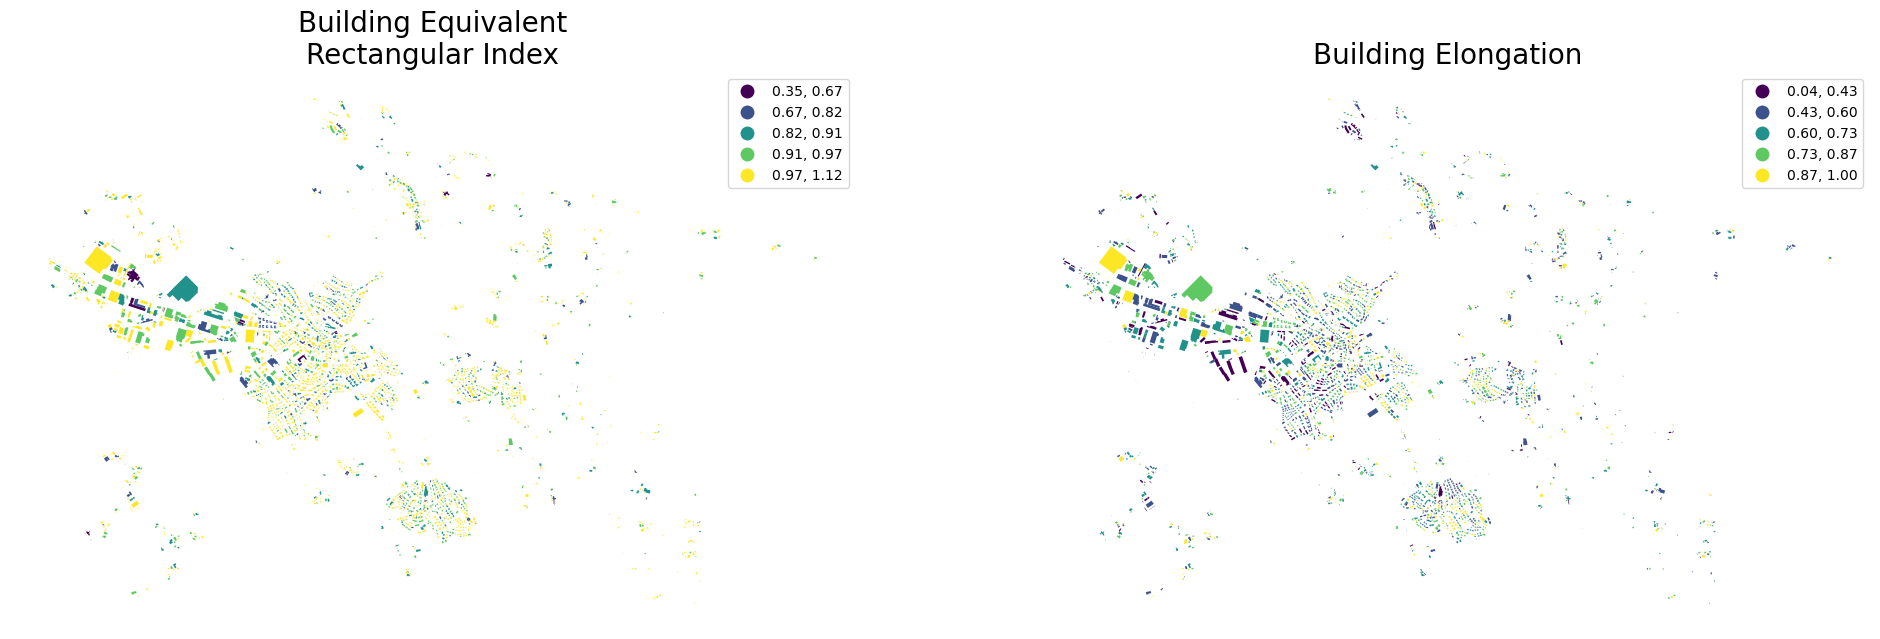

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Hinwil/eri_and_elongation.svg')  

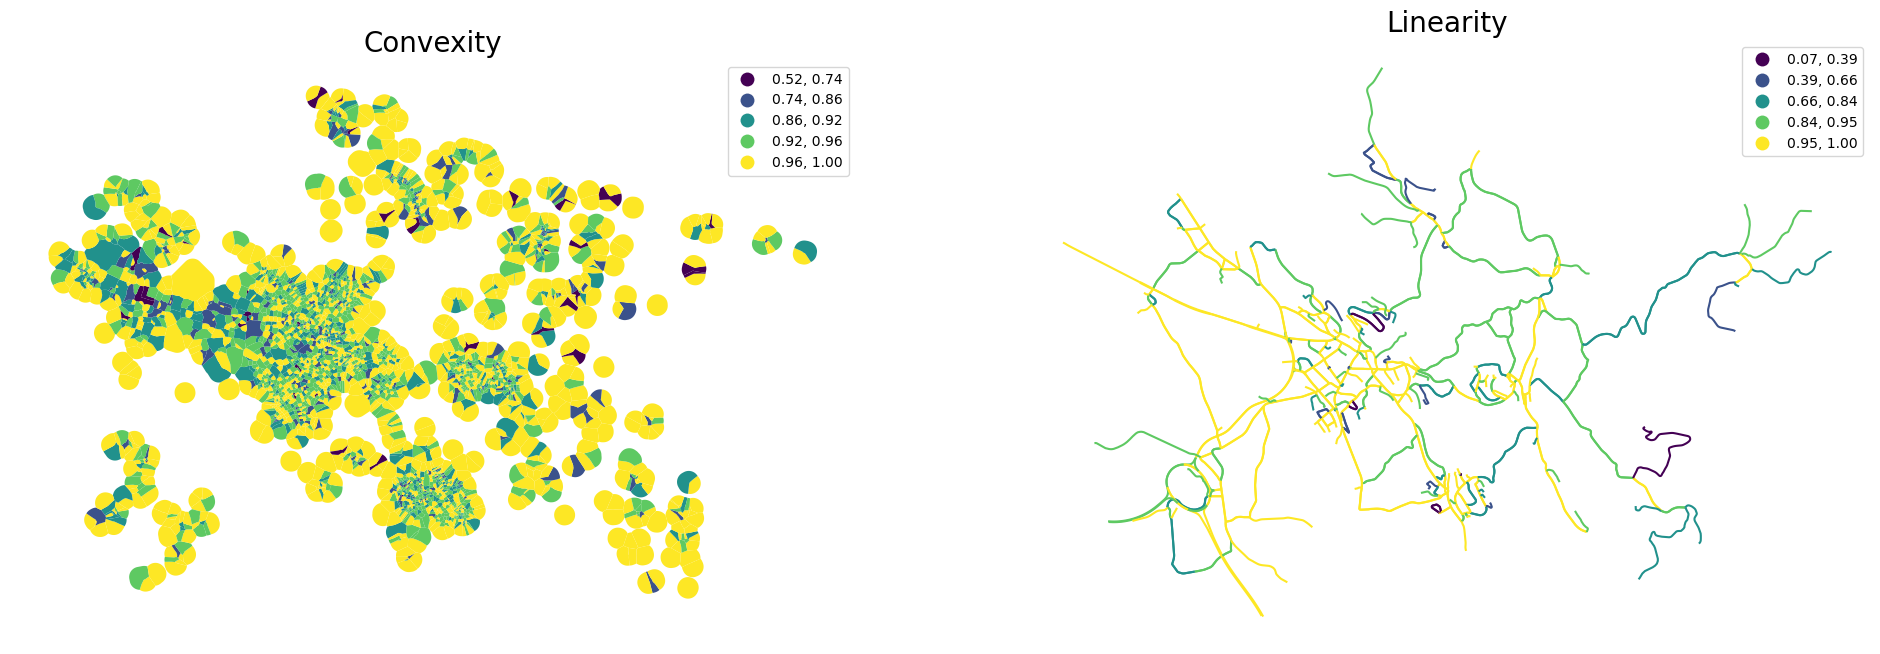

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Hinwil/convexity_and_linearity.svg')  

### Spatial distribution

In [35]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)


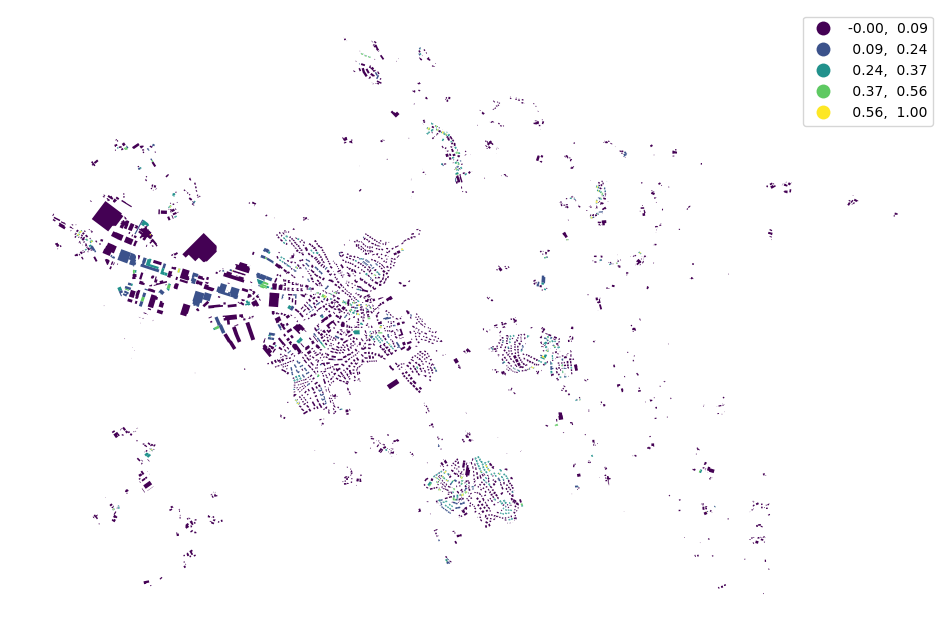

In [36]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Hinwil/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [37]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [38]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


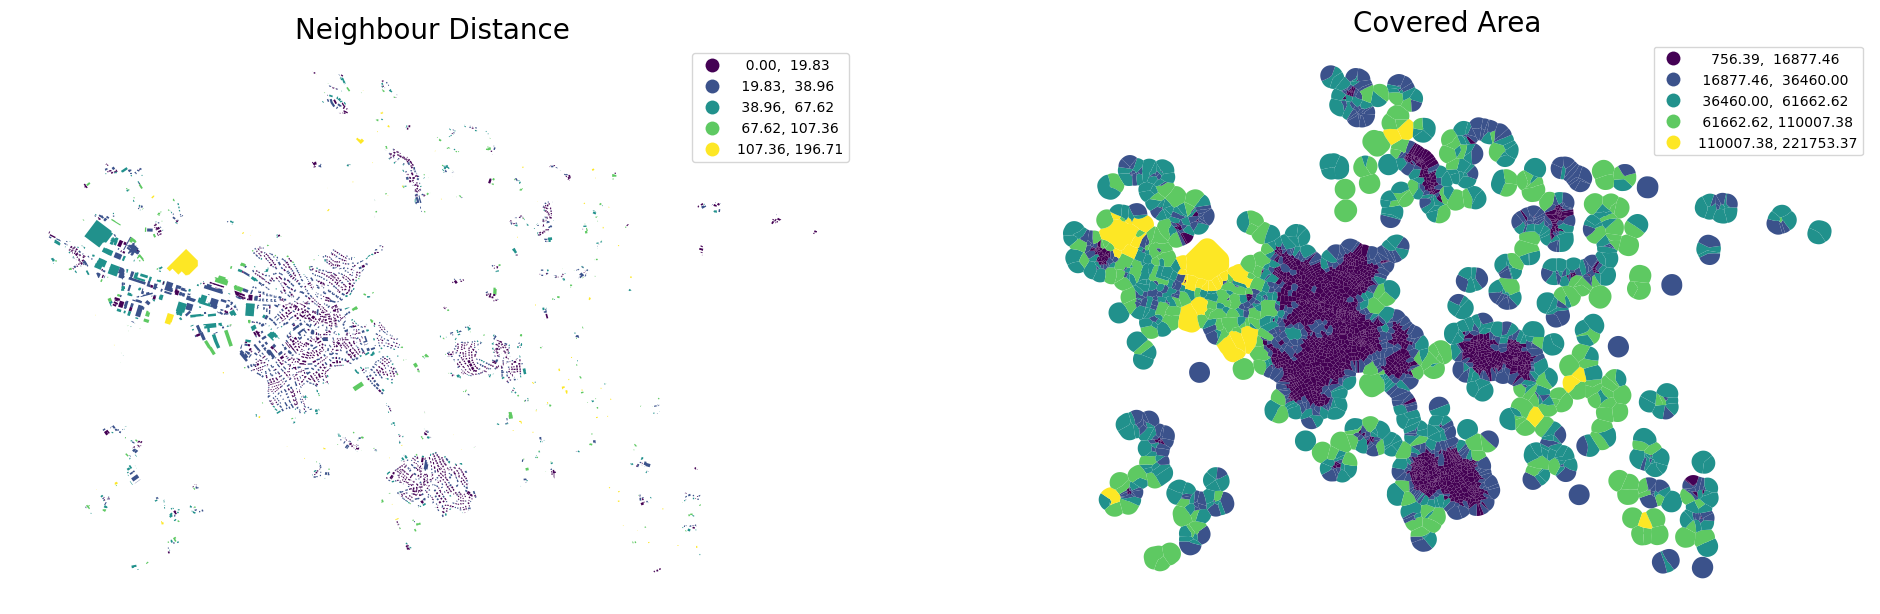

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Hinwil/neighbourdist_and_coveredarea.svg')  

In [40]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [41]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [42]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


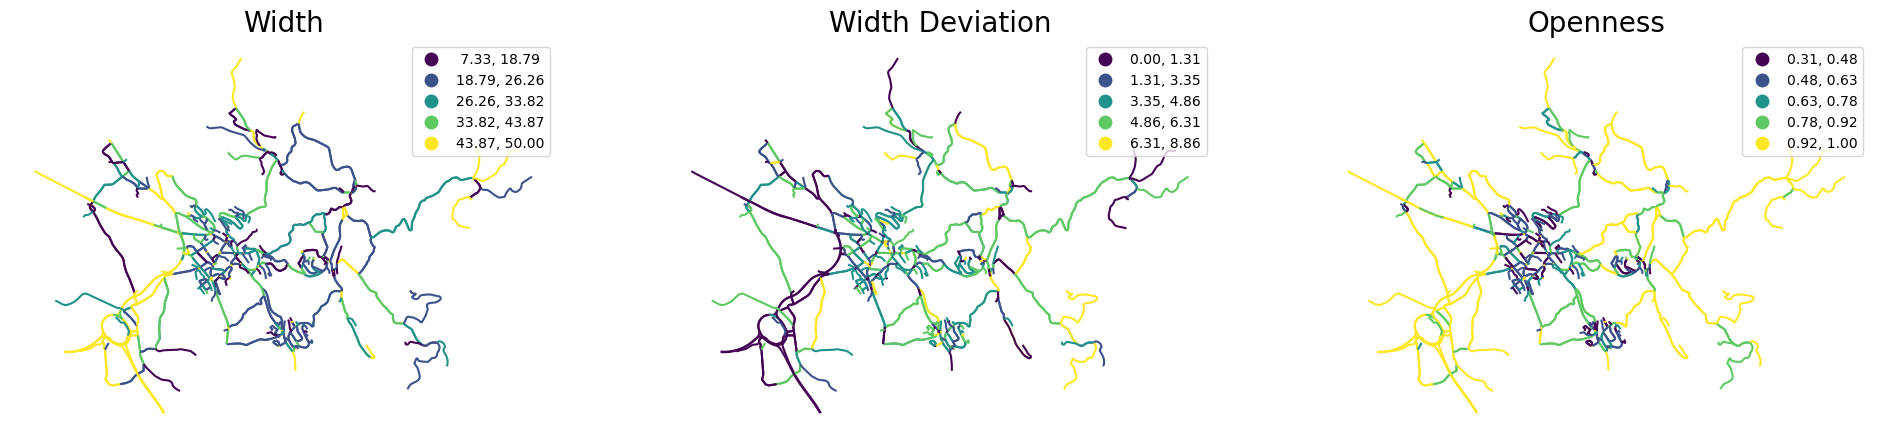

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Hinwil/road_network.svg')  

### Intensity

In [44]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


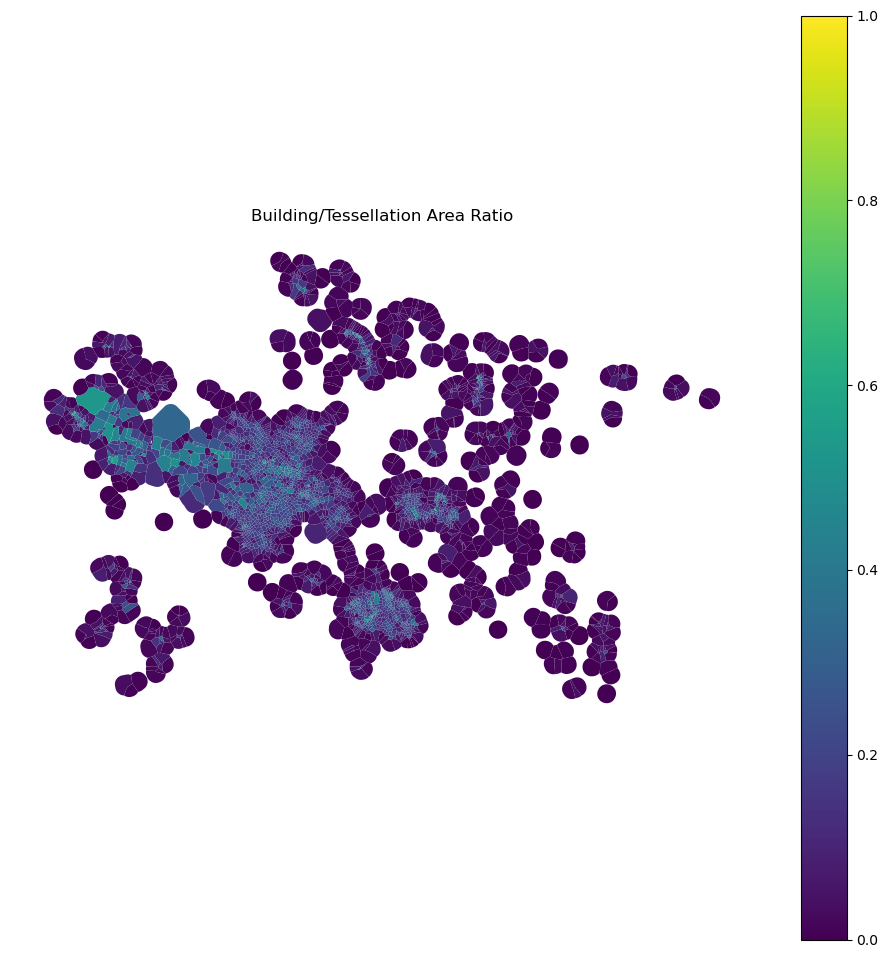

In [45]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Hinwil/tessellation_ratio.svg')  

### Connectivity

In [46]:
graph = momepy.gdf_to_nx(streets)

In [47]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

In [48]:
nodes, streets = momepy.nx_to_gdf(graph)

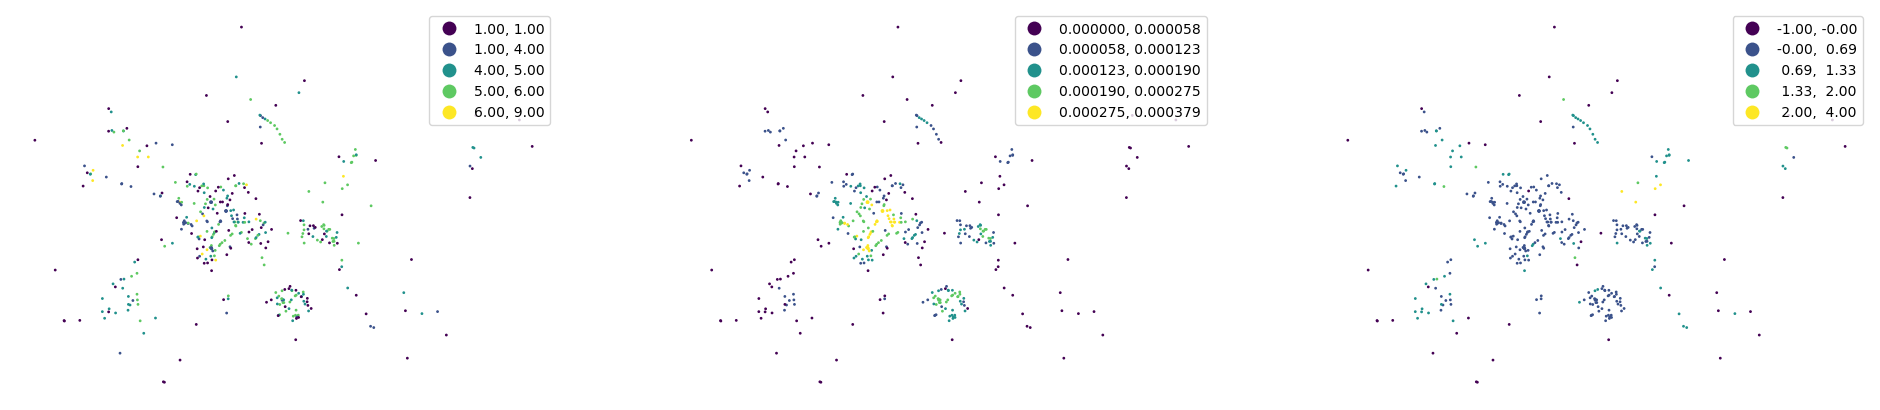

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Hinwil/connectivity.svg')  

In [50]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/3371 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [51]:
tessellation

uID                                           geometry  nID  \
0     1752  POLYGON ((2704495.922 1237552.399, 2704496.605...  331   
1     1751  POLYGON ((2704556.814 1237710.500, 2704557.156...  331   
2     1741  POLYGON ((2703991.313 1238223.035, 2704028.248...  718   
3     1742  POLYGON ((2704037.482 1238121.010, 2704040.251...  424   
4     1743  POLYGON ((2704166.599 1238067.697, 2704166.264...  722   
...    ...                                                ...  ...   
3366  2467  POLYGON ((2704530.376 1241367.296, 2704529.732...  725   
3367  2458  POLYGON ((2704442.841 1241348.375, 2704426.680...  565   
3368  2459  POLYGON ((2704365.066 1241321.127, 2704363.107...  565   
3369  2464  POLYGON ((2704554.620 1241392.480, 2704553.849...  725   
3370  1711  POLYGON ((2706173.383 1242298.480, 2706169.817...  406   

              area  convexity  neighbors  covered_area       car  
0     14197.776303   0.993425   0.004365  74464.499145  0.006100  
1     30705.358000   0.936414   0.002924  74464.499145  0.033955  
2     11854.038742   0.989468   0.007114  47620.617115  0.008663  
3     17243.528492   0.998736   0.007986  66441.457194  0.004144  
4     18820.840078   0.990412   0.005465  63073.491846  0.032214  
...            ...        ...        ...           ...       ...  
3366   2891.204794   0.913702   0.021516  39727.450163  0.098264  
3367   5417.540138   0.925430   0.013436  46781.051256  0.104294  
3368  18753.887710   0.957124   0.011488  58199.318663  0.076637  
3369  17266.101277   0.980555   0.007807  36744.611219  0.017004  
3370  14286.300435   0.999368   0.002134  27155.035095  0.000276  

[3371 rows x 8 columns]

In [52]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [53]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [54]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_37169/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [55]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [56]:
percentiles_joined

area_x_25     area_x_50     area_x_75  convexity_25  convexity_50  \
0     21879.570573  29561.364842  30133.361421      0.964919      0.993425   
1     21879.570573  29561.364842  30133.361421      0.964919      0.993425   
2       667.535253   3661.049283  14548.783617      0.889054      0.940970   
3       667.535253   3661.049283  14548.783617      0.889054      0.940970   
4       674.586107   2816.295040  11854.038742      0.892062      0.953220   
...            ...           ...           ...           ...           ...   
3366   1885.186915   5517.753323  10732.565613      0.934880      0.976937   
3367   1554.919709   4731.174353   9520.243873      0.941363      0.961254   
3368   1554.919709   5417.540138  10009.597739      0.943600      0.969100   
3369   1885.186915   5517.753323  10732.565613      0.934880      0.976937   
3370  11248.175555  11691.923328  12868.734660      0.994189      0.996732   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         0.995696      0.003036      0.003149      0.003757     74464.499145   
1         0.995696      0.003036      0.003149      0.003757     74464.499145   
2         0.989476      0.011033      0.019080      0.037468     19595.010068   
3         0.989476      0.011033      0.019080      0.037468     19595.010068   
4         0.989483      0.011963      0.017316      0.029040     20287.192988   
...            ...           ...           ...           ...              ...   
3366      0.981188      0.013977      0.017487      0.022390     34356.831535   
3367      0.981081      0.013751      0.018438      0.023635     32540.021097   
3368      0.981188      0.011880      0.018298      0.023635     26785.330101   
3369      0.981188      0.013977      0.017487      0.022390     34356.831535   
3370      0.998635      0.003248      0.006518      0.016647     38846.958423   

      ...          y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...  1.237561e+06        4.0        4.0        4.0      0.000000   
1     ...  1.237561e+06        4.0        4.0        4.0      0.000000   
2     ...  1.238272e+06        1.0        1.0        5.0      0.000025   
3     ...  1.238272e+06        1.0        1.0        5.0      0.000025   
4     ...  1.238272e+06        1.0        1.0        5.0      0.000025   
...   ...           ...        ...        ...        ...           ...   
3366  ...  1.241369e+06        5.0        6.0        6.0      0.000070   
3367  ...  1.241375e+06        5.0        5.5        6.0      0.000070   
3368  ...  1.241375e+06        5.0        5.0        6.0      0.000063   
3369  ...  1.241369e+06        5.0        6.0        6.0      0.000070   
3370  ...  1.242291e+06        5.0        5.0        5.0      0.000000   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0         0.000000      0.000000      -0.000000       0.000000      -0.000000  
1         0.000000      0.000000      -0.000000       0.000000      -0.000000  
2         0.000025      0.000026       1.000000       1.000000       1.000000  
3         0.000025      0.000026       1.000000       1.000000       1.000000  
4         0.000025      0.000026       1.000000       1.000000       1.000000  
...            ...           ...            ...            ...            ...  
3366      0.000077      0.000098       0.636364       0.748252       0.769231  
3367      0.000079      0.000094       0.636364       0.681818       0.769231  
3368      0.000079      0.000090       0.636364       0.636364       0.769231  
3369      0.000077      0.000098       0.636364       0.748252       0.769231  
3370      0.000000      0.000000       0.000000       0.000000       0.000000  

[3371 rows x 66 columns]

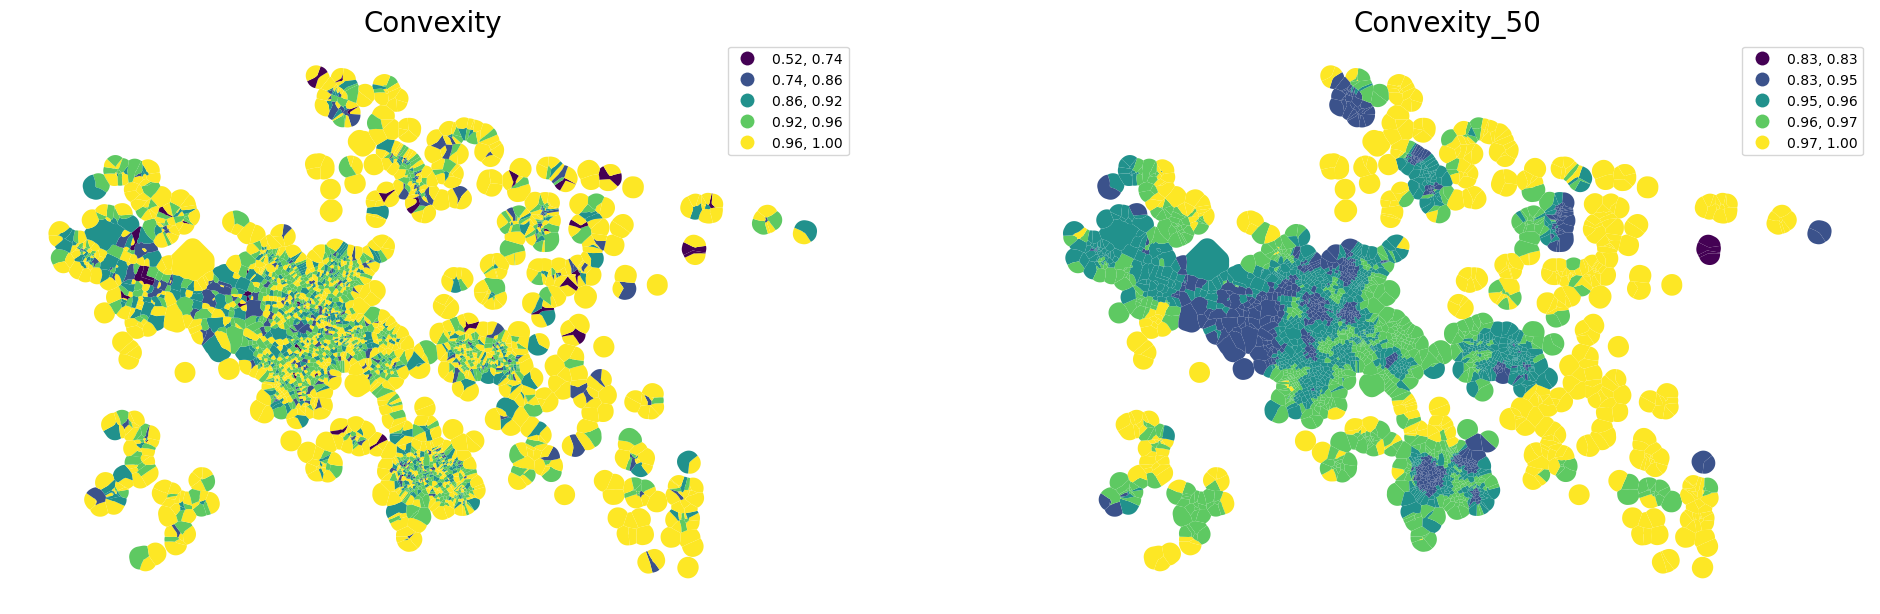

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Hinwil/convexity.svg')  

## Clustering

Standardize values before clustering.

In [58]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [59]:
standardized

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  \
0      7.209870   7.286181   4.855817      1.714160      2.543734   
1      7.209870   7.286181   4.855817      1.714160      2.543734   
2     -0.321427   0.244688   1.844823     -1.633708     -1.183617   
3     -0.321427   0.244688   1.844823     -1.633708     -1.183617   
4     -0.318924   0.015025   1.324189     -1.500958     -0.313133   
...         ...        ...        ...           ...           ...   
3366   0.110898   0.749468   1.107517      0.388551      1.372116   
3367  -0.006363   0.535622   0.873292      0.674652      0.257728   
3368  -0.006363   0.722223   0.967837      0.773347      0.815248   
3369   0.110898   0.749468   1.107517      0.388551      1.372116   
3370   3.435211   2.428034   1.520232      3.005776      2.778725   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         1.935284     -1.804905     -2.158158     -2.485996         4.427715   
1         1.935284     -1.804905     -2.158158     -2.485996         4.427715   
2         1.288746     -1.205174     -1.118234     -0.511858         0.404860   
3         1.288746     -1.205174     -1.118234     -0.511858         0.404860   
4         1.289522     -1.135378     -1.233364     -1.005410         0.455609   
...            ...           ...           ...           ...              ...   
3366      0.427345     -0.984375     -1.222186     -1.394818         1.487149   
3367      0.416249     -1.001315     -1.160145     -1.321945         1.353947   
3368      0.427345     -1.141635     -1.169246     -1.321945         0.932031   
3369      0.427345     -0.984375     -1.222186     -1.394818         1.487149   
3370      2.240817     -1.789050     -1.938265     -1.731122         1.816351   

      ...      y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ... -2.295952   0.063097  -0.741173  -1.531257     -1.352337   
1     ... -2.295952   0.063097  -0.741173  -1.531257     -1.352337   
2     ... -1.571104  -1.481951  -2.823828  -0.626460     -1.018708   
3     ... -1.571104  -1.481951  -2.823828  -0.626460     -1.018708   
4     ... -1.571104  -1.481951  -2.823828  -0.626460     -1.018708   
...   ...       ...        ...        ...        ...           ...   
3366  ...  1.585610   0.578114   0.647265   0.278337     -0.436100   
3367  ...  1.591718   0.578114   0.300155   0.278337     -0.436100   
3368  ...  1.591718   0.578114  -0.046954   0.278337     -0.529162   
3369  ...  1.585610   0.578114   0.647265   0.278337     -0.436100   
3370  ...  2.526435   0.578114  -0.046954  -0.626460     -1.352337   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0        -1.483899     -1.590259      -1.163039      -1.158138      -1.189781  
1        -1.483899     -1.590259      -1.163039      -1.158138      -1.189781  
2        -1.195673     -1.324438       1.092020       0.721440       0.486317  
3        -1.195673     -1.324438       1.092020       0.721440       0.486317  
4        -1.195673     -1.324438       1.092020       0.721440       0.486317  
...            ...           ...            ...            ...            ...  
3366     -0.612016     -0.575030       0.271998       0.248260       0.099525  
3367     -0.584039     -0.613111       0.271998       0.123393       0.099525  
3368     -0.584039     -0.651192       0.271998       0.037957       0.099525  
3369     -0.612016     -0.575030       0.271998       0.248260       0.099525  
3370     -1.483899     -1.590259      -1.163039      -1.158138      -1.189781  

[3371 rows x 66 columns]

### How many clusters?

In [60]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.034 seconds.
K=3 fitted in 0.041 seconds.
K=4 fitted in 0.041 seconds.
K=5 fitted in 0.055 seconds.
K=6 fitted in 0.078 seconds.
K=7 fitted in 0.074 seconds.
K=8 fitted in 0.064 seconds.
K=9 fitted in 0.073 seconds.
K=10 fitted in 0.092 seconds.
K=11 fitted in 0.090 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [61]:
show(cgram.bokeh())

In [62]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   1   0   3   4   5   4   1   8   6   2
1   0   1   0   3   4   5   4   1   8   6   2
2   0   1   2   1   3   1   0   0   3   1   4
3   0   1   2   1   3   1   0   0   3   1   4
4   0   1   2   1   3   1   0   0   3   1   4

In [63]:
merged["cluster"] = cgram.labels[8].values

In [64]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [65]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [66]:
urban_types.to_file('../data/raw/Hinwil.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>